In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style("whitegrid")

# Load the cleaned dataframes using the corrected paths
# The '../' moves the path up one directory level
crop_df = pd.read_csv('../data/processed/cleaned_crop_yield.csv')
climate_df = pd.read_csv('../data/processed/cleaned_climate.csv')
co2_df = pd.read_csv('../data/processed/cleaned_co2.csv')

# Convert the 'dt' column back to datetime
# It was saved as a string in the CSV
climate_df['dt'] = pd.to_datetime(climate_df['dt'])

print("Cleaned data loaded for EDA.")

Cleaned data loaded for EDA.


In [17]:
print("Crop Data Overview:")
print(crop_df.head())
print("\nClimate Data Overview:")
print(climate_df.head())
print("\nCO2 Data Overview:")
print(co2_df.head())

Crop Data Overview:
                    State_Name District_Name  Crop_Year       Season  \
0  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
1  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
2  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
3  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
4  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    

                  Crop    Area  Production  
0             Arecanut  1254.0      2000.0  
1  Other Kharif pulses     2.0         1.0  
2                 Rice   102.0       321.0  
3               Banana   176.0       641.0  
4            Cashewnut   720.0       165.0  

Climate Data Overview:
          dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0 1743-11-01               6.068                          1.737  Århus   
1 1744-04-01               5.788                          3.624  Århus   
2 1744-05-01              10.64

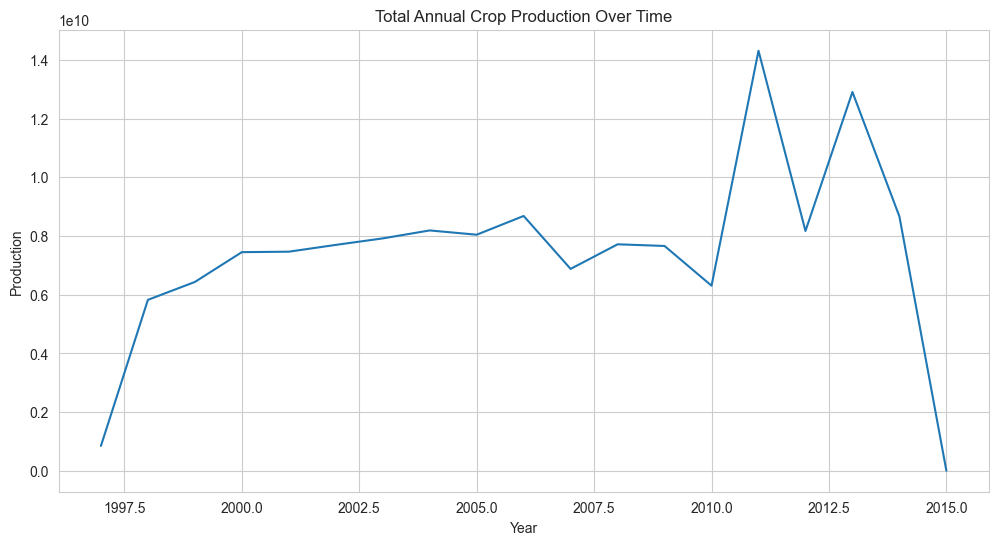

In [18]:
# Group by 'Crop_Year' and sum the 'Production'
annual_production = crop_df.groupby('Crop_Year')['Production'].sum().reset_index()

# Plot the trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=annual_production, x='Crop_Year', y='Production')
plt.title('Total Annual Crop Production Over Time')
plt.xlabel('Year')
plt.ylabel('Production')
plt.show()

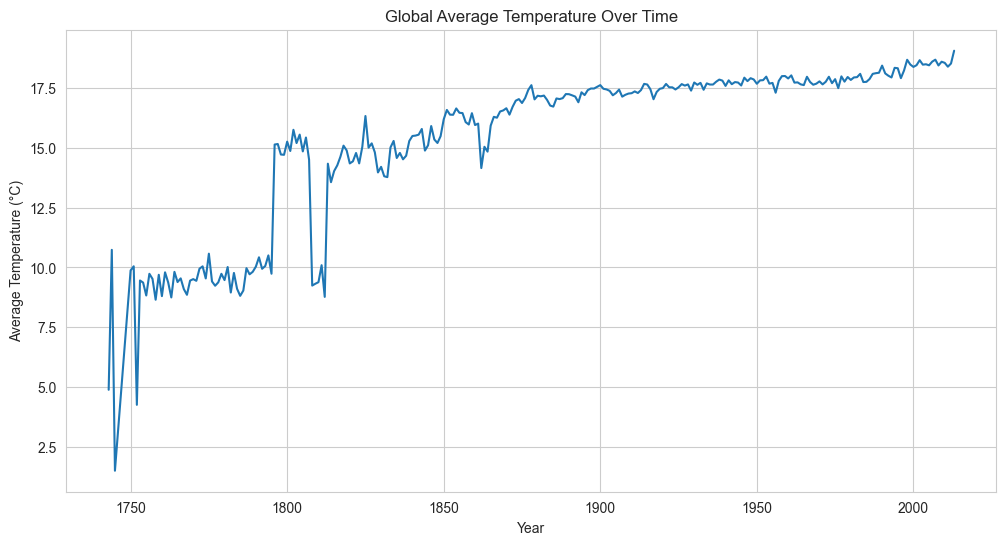

In [19]:
# Extract the year from the 'dt' column
climate_df['Year'] = climate_df['dt'].dt.year

# Group by 'Year' and find the mean temperature
annual_temp = climate_df.groupby('Year')['AverageTemperature'].mean().reset_index()

# Plot the trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=annual_temp, x='Year', y='AverageTemperature')
plt.title('Global Average Temperature Over Time')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.show()

c:\Users\Devnaam_priyadershi\Desktop\climate-food-supply\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


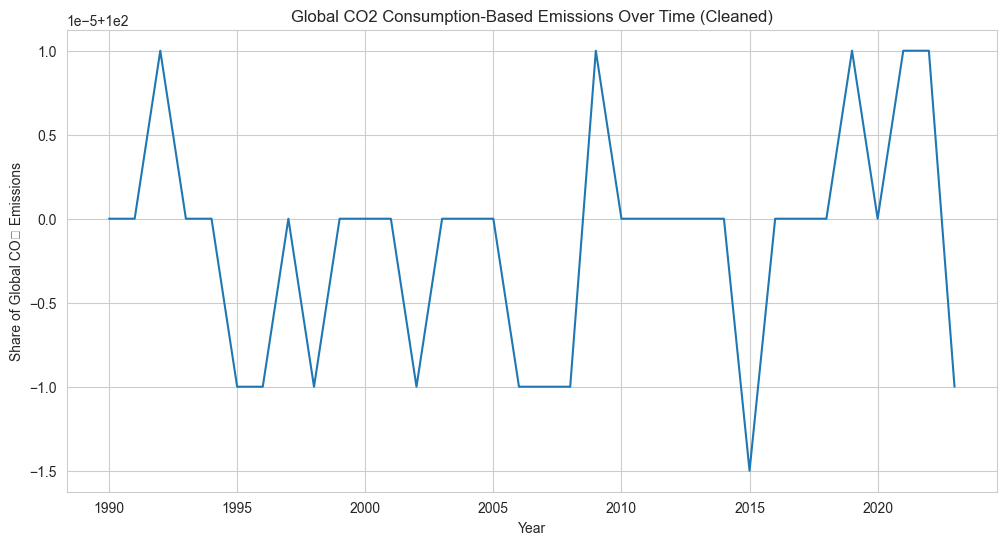

In [ ]:
# Filter the CO2 data for the 'World' entity to get global emissions
co2_world_df = co2_df[co2_df['Entity'] == 'World']

# Let's filter for years that align with our other datasets (e.g., after 1900)
co2_world_df = co2_world_df[co2_world_df['Year'] >= 1900]

# Now, let's plot it again to see a meaningful trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=co2_world_df, x='Year', y='Share of global annual CO₂ consumption-based emissions')
plt.title('Global CO2 Consumption-Based Emissions Over Time (Cleaned)')
plt.xlabel('Year')
plt.ylabel('Share of Global CO₂ Emissions')
plt.show()

In [22]:
# --- Aligning Crop Data ---
# The crop data is for India, let's add a 'Country' column
crop_df['Country'] = 'India'

# Group by 'Year' and 'Country' to get total production per year for India
india_production_df = crop_df.groupby(['Crop_Year', 'Country'])['Production'].sum().reset_index()
india_production_df.rename(columns={'Crop_Year': 'Year'}, inplace=True)
print("India Production data aligned:")
print(india_production_df.head())

# --- Aligning Climate Data ---
# Group by 'Year' and 'Country' to get the average temperature for each country
avg_temp_by_country_year = climate_df.groupby(['Year', 'Country'])['AverageTemperature'].mean().reset_index()
print("\nAverage Temperature per Country per Year aligned:")
print(avg_temp_by_country_year.head())

India Production data aligned:
   Year Country    Production
0  1997   India  8.512329e+08
1  1998   India  5.825321e+09
2  1999   India  6.434666e+09
3  2000   India  7.449709e+09
4  2001   India  7.465541e+09

Average Temperature per Country per Year aligned:
   Year                 Country  AverageTemperature
0  1743                 Albania           12.686000
1  1743                 Austria            2.607800
2  1743                 Belarus            1.128875
3  1743                 Belgium            7.363571
4  1743  Bosnia And Herzegovina            6.615800


In [23]:
# --- Step 1: Merge Production and Climate Data ---
# We'll merge these two based on 'Year' and 'Country'
merged_df = pd.merge(india_production_df, avg_temp_by_country_year, on=['Year', 'Country'], how='inner')
print("Merged Production and Climate data:")
print(merged_df.head())

# --- Step 2: Merge with CO2 Data ---
# The CO2 data is global ('World'), so we can't join it by country directly.
# Instead, we'll perform a separate merge based only on 'Year'.
# We need to make sure the CO2 dataframe is cleaned first (as done above)
co2_world_df = co2_df[co2_df['Entity'] == 'World'].copy() # Use .copy() to avoid SettingWithCopyWarning
co2_world_df = co2_world_df[co2_world_df['Year'] >= 1900]
co2_world_df.rename(columns={'Share of global annual CO₂ consumption-based emissions': 'Global_CO2_Emissions'}, inplace=True)

# Merge the primary dataframe with the global CO2 data on 'Year'
final_merged_df = pd.merge(merged_df, co2_world_df[['Year', 'Global_CO2_Emissions']], on='Year', how='left')

# Check the final merged dataframe
print("\nFinal Merged DataFrame:")
print(final_merged_df.info())
print(final_merged_df.head())

Merged Production and Climate data:
   Year Country    Production  AverageTemperature
0  1997   India  8.512329e+08           25.549448
1  1998   India  5.825321e+09           26.219083
2  1999   India  6.434666e+09           26.158038
3  2000   India  7.449709e+09           25.981148
4  2001   India  7.465541e+09           26.045342

Final Merged DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  17 non-null     int64  
 1   Country               17 non-null     object 
 2   Production            17 non-null     float64
 3   AverageTemperature    17 non-null     float64
 4   Global_CO2_Emissions  17 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 812.0+ bytes
None
   Year Country    Production  AverageTemperature  Global_CO2_Emissions
0  1997   India  8.512329e+08       

In [24]:
# Save the final merged dataframe to the processed data folder
final_merged_df.to_csv('../data/processed/integrated_data.csv', index=False)
print("\nIntegrated data saved to 'data/processed/integrated_data.csv'.")


Integrated data saved to 'data/processed/integrated_data.csv'.
